In [240]:
import cv2
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import math
from torch import autograd
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [241]:
os.path.split(os.getcwd())[0]

'/Users/maoli/PycharmProjects'

In [242]:
from game.flappy_bird import GameState

In [243]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [244]:
import numpy as np

class FlappyBirdEnd:
    def __init__(self, framNum):
        self.framNum = framNum
        self.game = GameState()
        self.reset()
        
    def image_to_tensor(self, image):
        image_tensor = image.transpose(2, 0, 1)
        image_tensor = image_tensor.astype(np.float32)
        image_tensor = torch.from_numpy(image_tensor)
        if torch.cuda.is_available():
            image_tensor = image_tensor.cuda()
        return image_tensor

    def resize_and_bgr2gray(self, image):
        image = image[0:288, 0:404]
        image_data = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
        image_data[image_data > 0] = 255
        image_data = np.reshape(image_data, (84, 84, 1))
        return image_data

    def reset(self):
        action = np.zeros([2], dtype=np.float32)
        action[0] = 1
        image_data, reward, terminal = self.game.frame_step(action)
        image_data = self.resize_and_bgr2gray(image_data)
        image_data = image_to_tensor(image_data)
        #self.state's shape is (1,4,84,84)
        img_stack = np.concatenate((image_data, image_data))# --> (2,84,84)
        for i in range(2, self.framNum):
            img_stack = np.concatenate((image_data, img_stack)) #--> (N,84,84)
        self.state = img_stack
        return self.state
            
        
    
    def step(self, action):
        act = np.zeros([self.framNum])
        act[action]=1
        image_data, reward, done = self.game.frame_step(act)
        image_data = resize_and_bgr2gray(image_data)
        image_data = image_to_tensor(image_data)   # shape(84,84)
        
        least_img = self.state[1:,:,:]      # shape(framNum-1,84,84)
        self.state = np.concatenate((image_data, least_img)) # --> (framNum,84,84)
        
        
        return self.state, reward,done

## Pre-prograssing

In [245]:
def image_to_tensor(image):
    image_tensor = image.transpose(2, 0, 1)
    image_tensor = image_tensor.astype(np.float32)
    image_tensor = torch.from_numpy(image_tensor)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
    return image_tensor


def resize_and_bgr2gray(image):
    image = image[0:288, 0:404]
    image_data = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
    image_data[image_data > 0] = 255
    image_data = np.reshape(image_data, (84, 84, 1))
    return image_data

def preprograssing(image):
    image = resize_and_bgr2gray(image)
    image = image_to_tensor(image)
    return image

## Use Cuda

In [246]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Memory replay

In [247]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

# Computation Loss

In [248]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## Hyper parameters

In [249]:
num_frames = 2* 1000 * 1000
batch_size = 32
gamma      = 0.99
num_actions = 2
replay_buffer_size = 10 * 1000
replay_initial = 5 * 1000 

## Double Deep Q-network

In [250]:
class CnnDQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(CnnDQN, self).__init__()
    
        self.conv1 = nn.Conv2d(4, 32, 8, 4)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(3136, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, num_actions)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = out.view(out.size()[0], -1)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(num_actions)
        return action

## Synchronize current policy net and target net

In [251]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [252]:
current_model = CnnDQN((4, 84, 84), num_actions)
target_model  = CnnDQN((4, 84, 84), num_actions)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=1e-6)


replay_buffer = ReplayBuffer(replay_buffer_size)

update_target(current_model, target_model)

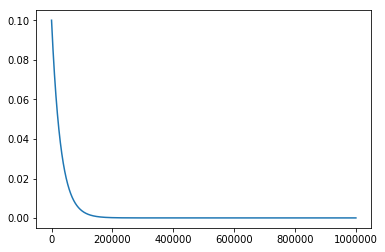

In [253]:
epsilon_start = 0.1
epsilon_final = 0.0001
epsilon_decay = 30000


epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [254]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s k. reward: %s' % (int(frame_idx/1000), np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

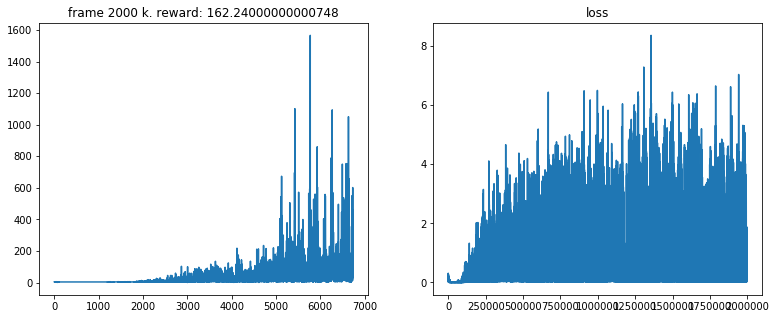

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [255]:
losses = []
all_rewards = []
episode_reward = 0


env = FlappyBirdEnd(4)

state = env.reset()


for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    next_state, reward, done = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data.item())
      
    if frame_idx % 50 == 0:
        plot(frame_idx, all_rewards, losses)
     
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)

几个技术细节值得注意一下：
1. env.step --> state 是单个state， 所以传入CNN的时候要在axis=0 加上一个维度
2. buffer_replay sample 出来的 的tensor shape是 (bath_size,frame,80,80) 


In [258]:
PARA_PATH = "/Users/maoli/Desktop/TrainedFlappyBird.pt"
torch.save(current_model.state_dict(), PARA_PATH)

In [259]:
model = CnnDQN((4, 84, 84), num_actions)
model.load_state_dict(torch.load(PARA_PATH))